Assignment 1 - Cliff Walking

Compare Sarsa and Q-learning for the gridworld in the diagram below using ε-greedy and UCB based action selection.

![title](img/cliffWalking.png)

It is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is −1 on all transitions except those into the the region marked “The Cliff.” Stepping into this region incurs a reward of −100 and sends the agent instantly back to the start. 


In [37]:
import numpy as np
import random
from math import log
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

Helper Functions - Implementation of ε-greedy and UCB action selection

In [38]:
#ε-greedy action selection
"""
qsa- Action value function
y,x - Coordinates of current state
epsilon - ε-greedy parameter
"""

def epsilonGreedy(qsa,y,x,epsilon):
    if random.uniform(0, 1) < epsilon:    #Explore: Select action at random
        action = random.randrange(4)
    else:                                 #Exploit: Select action based on maximum action value, use random to break ties
        action=np.random.choice(np.flatnonzero(qsa[y][x] == qsa[y][x].max())) 
    return action

In [39]:
#Upper Confidence Bound action selection
"""
qsa- Action value function
y,x - Coordinates of current state
c - UCB sensitivity parameter
nt - Number of times action selected in current state
t- Time elapsed
"""

def ucb(qsa,y,x,c,nt,t):
    temp=qsa[y][x]+c*((log(t)/(nt[y-1][x-1]+0.0001))**1/2)
    action=np.random.choice(np.flatnonzero(temp == temp.max()))
    return action

In [72]:
#Updating next state
def nextState(y,x,action):
    tempx=x
    tempy=y
    if action==0:
        tempx=x-1
    elif action==1:
        tempy=y-1
    elif action==2:
        tempx=x+1
    elif action==3:
        tempy=y+1
    return tempx,tempy

#Visualizing Path
def findPath(qsa):
    pathx=[]
    pathy=[]
    x=1
    y=b
    pathx.append(x)
    pathy.append(y)
    while x!=l or y!=b:
        action=np.random.choice(np.flatnonzero(qsa[y][x] == qsa[y][x].max()))
        x,y=nextState(y,x,action)
        pathx.append(x)
        pathy.append(y)
    return pathx,pathy

SARSA Algorithm

In [91]:
def sarsa(policy="epsilonGreedy",onOff="on",epsilon0=0.1,c=0.1,b=4,l=12,reward=-1,cliffReward=-100):
    # Algorithm parameters
    numIter=500                      #Number of iterations of the algorithm
    alpha=0.5                         #Learning Rate
    gamma=1                          # Discount Factor - Set to 1 as this is an undiscounted task

    # Initialize the action value function and the number of times action tied in state to be zero for all state action pairs.
    qsa=np.zeros((b+2,l+2,4))    #For each state there are 4 possible actions
    nt=np.zeros((b,l,4))

    rewards=[]               #Array to maintain the rewards for each iteration
    t=1                      #Counter for measuring time elapsed

    for _ in range(numIter):
        # Initialize starting position and temporary variables
        y=tempy=b
        x=tempx=1
        sumReward=0

        epsilon=epsilon0    #/(numIter//100+1)            #Reduce Epsilon as time progresses

        while True:

            if x==l and y==b:
                rewards.append(sumReward)
                break

            # Based on policy identify ifthe algorithm should explore or exploit and select action 0-Left, 1-Up, 2-Right, 3-Down
            if policy=="epsilonGreedy":
                action=epsilonGreedy(qsa,y,x,epsilon)
            elif policy =="ucb":
                action=ucb(qsa,y,x,c,nt,t)

            # Update the next state
            tempx,tempy =nextState(y,x,action)

            # Identify the next state and the reward
            if tempx==0 or tempy==0 or tempx==l+1 or tempy==b+1:          #Check if the next state falls off the grid
                qsa[y][x][action]+=alpha*(reward+gamma*qsa[tempy][tempx][0]-qsa[y][x][action])

                if onOff=="off":
                    actionPrime=epsilonGreedy(qsa,y,x,0)
                elif onOff=="on":
                    if policy=="epsilonGreedy":
                        actionPrime=epsilonGreedy(qsa,y,x,epsilon)
                    elif policy =="ucb":
                        actionPrime=ucb(qsa,y,x,c,nt,t)

                qsa[tempy][tempx][0]+=alpha*(reward+gamma*qsa[y][x][actionPrime]-qsa[tempy][tempx][0])
                sumReward+=2*reward 

            elif tempy==b and tempx>1 and tempx<l:                    #Check if the next state falls off the cliff
                qsa[y][x][action]+=alpha*(cliffReward+gamma*qsa[tempy][tempx][0]-qsa[y][x][action])

                if onOff=="off":
                    actionPrime=epsilonGreedy(qsa,b,1,0)
                elif onOff=="on":
                    if policy=="epsilonGreedy":
                        actionPrime=epsilonGreedy(qsa,b,1,epsilon)
                    elif policy =="ucb":
                        actionPrime=ucb(qsa,b,1,c,nt,t)

                qsa[tempy][tempx][0]+=alpha*(reward+gamma*qsa[b][1][actionPrime]-qsa[tempy][tempx][0])
                x=1
                y=b
                sumReward+=cliffReward+reward

            else:                                           
                if onOff=="off":
                    actionPrime=epsilonGreedy(qsa,tempy,tempx,0)
                elif onOff=="on":
                    if policy=="epsilonGreedy":
                        actionPrime=epsilonGreedy(qsa,tempy,tempx,epsilon)
                    elif policy =="ucb":
                        actionPrime=ucb(qsa,tempy,tempx,c,nt,t)
                qsa[y][x][action]+=alpha*(reward+gamma*qsa[tempy][tempx][actionPrime]-qsa[y][x][action]) 
                x=tempx
                y=tempy
                sumReward+=reward

    #Identify path learnt by algorithm
    pathx,pathy=findPath(qsa)
    return rewards,pathx,pathy

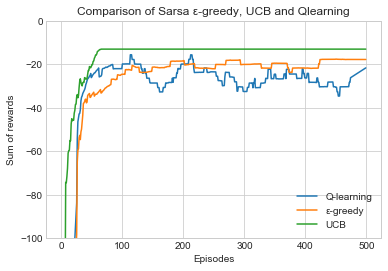

In [105]:
#Specify the grid world
b=4
l=12
reward=-1
cliffReward=-100

%matplotlib inline
plt.style.use('seaborn-whitegrid')
x = range(numIter)
plt.ylim(-100, 0)


rewards,pathx,pathy=sarsa(policy="epsilonGreedy",onOff="off",epsilon0=0.2,c=0.1,b=b,l=l,reward=reward,cliffReward=cliffReward)
yhat = savgol_filter(rewards,51, 1)
plt.plot(x,yhat,label="Q-learning")
rewards,pathx,pathy=sarsa(policy="epsilonGreedy",onOff="on",epsilon0=0.2,c=0.1,b=b,l=l,reward=reward,cliffReward=cliffReward)
yhat = savgol_filter(rewards,51, 1)
plt.plot(x,yhat,label="ε-greedy")
rewards,pathx,pathy=sarsa(policy="ucb",onOff="on",epsilon0=0.05,c=0.1,b=b,l=l,reward=reward,cliffReward=cliffReward)
yhat = savgol_filter(rewards,11, 1)
plt.plot(x,yhat,label="UCB")


plt.title('Comparison of Sarsa ε-greedy, UCB and Qlearning')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards')


plt.legend()

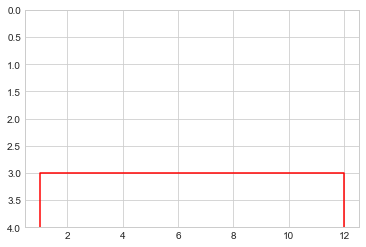

In [46]:
plt.plot(pathx,pathy, color='red')
plt.ylim(4, 0)
plt.show()

Sarsa and Q-learning methods with ε-greedy and UCB based action selection. 

Q-learning learns values for the optimal policy, that  travels right along the edge of the cliff. But this results in its occasionally falling off the cliff because of the ε-greedy action selection.Sarsa, on the other hand, takes the action selection into account and learns the longer but safer path through the upper part of the grid. 
Although Qlearning actually learns the values of the optimal policy, its on-line performance is worse than that of Sarsa, which learns the roundabout policy. 
UCB learns the optimal path with good online performance as the actions are selected based on the experience gained by exploring various actions in a given state a large number of times.